### Загрузка метрик

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

from datetime import datetime as dt
import json
import os

In [29]:
SCORE_PATH = "scores"
os.listdir(SCORE_PATH)

['pns50.json',
 'pns10.json',
 'pns20_attention.json',
 'pns50_attention.json',
 'pns10_attention.json',
 'pns5_attention.json',
 'pns20.json',
 'pns5.json']

In [30]:
for filename in os.listdir(SCORE_PATH):
    
    with open(f"{SCORE_PATH}/{filename}", "r") as file:  
        variable_name = filename.split('.')[0]
        exec(f"{variable_name} = {json.load(file)}")

In [49]:
pns5['TSAG-PNMLSTM-PNS5-EC50-BS10K-PCL25-PCLS0'][:2]

[{'roc_auc_score_test': 0.9301214812625718,
  'roc_auc_score_display': 0.9281200409810899,
  'loss': 0.1707544082345871,
  'iteration': 0,
  'timestamp': '2022-10-07 20:57:47.383679'},
 {'roc_auc_score_test': 0.9753508019965788,
  'roc_auc_score_display': 0.9733126506670918,
  'loss': 0.08562425583457718,
  'iteration': 1,
  'timestamp': '2022-10-07 20:59:44.425580'}]

### Воспроизведение результата

Обучил ```LSTM``` для размеров ```PNS``` = $[5, 10, 20, 50]$ на датасете ```big``` с параметрами:
* ```EC50``` количество эпох
* ```BS10K``` размер батча
* ```PCL25``` размер контекста
* ```PCLS``` = $[0, 0.15, 0.25, 0.5]$ доля правого контекста

Обучение проходило в облаке на двух инстансах (для каждого ```PNS```) с ресурсами ```vCPU = 2```, ```RAM = 16GB``` и заняло:

In [90]:
def hours_for_training(pns, mask = '%Y-%m-%d %H:%M:%S.%f'):
    job_ids = list(pns.keys())
    
    cvt_to_time = lambda x: dt.strptime(x, mask)
    
    return {
        job_id: (
            cvt_to_time(pns[job_id][-1]['timestamp']) - \
            cvt_to_time(pns[job_id][0]['timestamp'])
        ).
        total_seconds() / 3600
        for job_id in job_ids
    }

In [119]:
def plot_hours_for_training(pns_list, pns_labels):
    fig, ax = plt.subplots(figsize=(6, 4))

    pcls = ['0', '0.15', '0.25', '0.5']
    ax.set_xticks(range(len(pcls)))
    ax.set_xticklabels(pcls)
    ax.set_xlabel('PCLS', fontsize=12)

    ax.set_ylabel('Hours', fontsize=12)
    ax.set_title('Hours for training', fontsize=12)

    for i in range(len(pns_list)):
        pns_hours = hours_for_training(pns_list[i])
        ax.plot(
            pcls, list(pns_hours.values()), 
            marker='o', label=pns_labels[i]
        )

    ax.grid(); ax.legend(); plt.show()

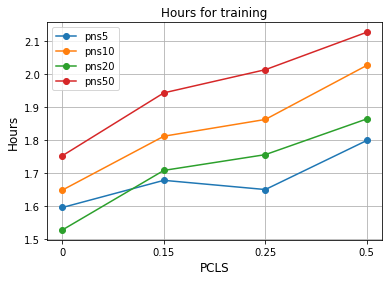

In [120]:
plot_hours_for_training([pns5, pns10, pns20, pns50], ['pns5', 'pns10', 'pns20', 'pns50'])

Размер контекста всегда одинаковый ```PCL``` $ = 25 $, но чем больше доля правого контекста тем больше времени уходит на обучение. Контринтуитивное наблюдение, возможно, просто случайность. Теперь посмотрим на метрики:

In [111]:
def plot_roc_auc_score(pns_list, pns_labels):

    fig, axes = plt.subplots(2, 2, figsize=(10,5))
    pcls = ['0', '0.15', '0.25', '0.5']

    def plot_one_pns(ax, pns):
        job_ids = list(pns.keys())
        for i, job_id in enumerate(job_ids):
            df = pd.DataFrame(pns[job_id]).set_index('iteration')
            ax.plot(df.index, df.roc_auc_score_test, label=pcls[i])
        ax.legend()

    for i in range(len(pns_list)):
        plot_one_pns(axes[i//2][i%2], pns_list[i])
        axes[i//2][i%2].set_title(pns_labels[i])

    fig.tight_layout()
    plt.show()

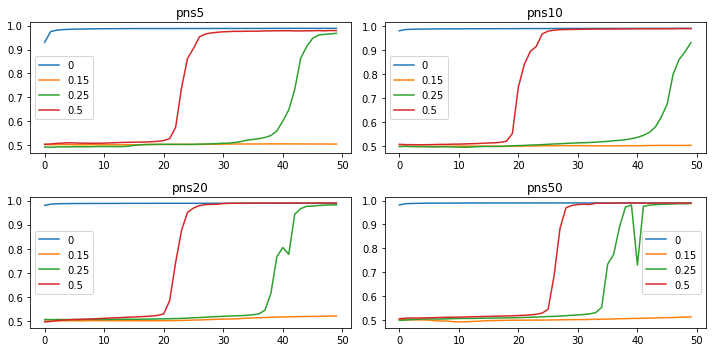

In [112]:
plot_roc_auc_score([pns5, pns10, pns20, pns50], ['pns5', 'pns10', 'pns20', 'pns50'])

Наблюдаемые дефекты:

* Медленная сходимость при включении правого контекста, при этом отсутствует зависимость между ```PCLS``` и скоростью сходимости (чем больше правый контекст тем медленнее сходимость)

* Обучение в минус

Помимо этого модель с параметром ```PLS015``` за ```50``` эпох не сходится, но растет, наверно я взял какие-то другие параметы, но в целом похоже.

Обучение ставил на ночь, утром обычные лстмки закончили обучение, сетки с ```attention``` завершили примерно половину, т.е. обычные лстмки обучаются примерно в ```2``` раза быстрее, но гипотеза была про другое.

###  Помогает ли attention убрать дефекты при смещенном контексте?

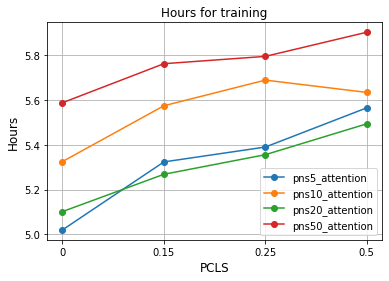

In [121]:
plot_hours_for_training([pns5_attention, pns10_attention, pns20_attention, pns50_attention], 
                        ['pns5_attention', 'pns10_attention', 'pns20_attention', 'pns50_attention']
)

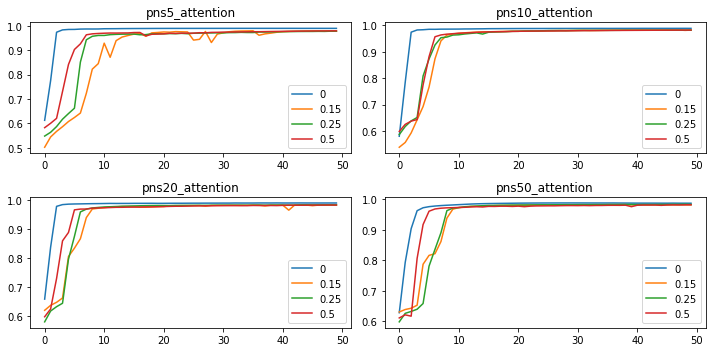

In [122]:
plot_roc_auc_score([pns5_attention, pns10_attention, pns20_attention, pns50_attention], 
                        ['pns5_attention', 'pns10_attention', 'pns20_attention', 'pns50_attention']
)

Из графиков видно, что сходимость для моделей с правым контекстом начинается примерно в одно и то же время на раннем этапе. Дефект медленной сходимости исчезает и нейросеть с ```attention``` начинает сходиться намного эпох быстрее чем обычная ```LSTM```, но вопрос здесь такой: 

*Нам есть куда торопиться?* Ведь в конце концов и обычная лстмка сойдется, при этом ее архитектура проще, и для завершения полного цикла обучения ей нужно в два раза меньше времени. Помимо этого:
* Дефект с обучением в минус остается, а это значит что модель может повести себя нестабильно на каком-то этапе обучения и уменьшить количество эпох будет плохой идеей. Особенно неприятно видеть это на графике ```pns5_attention```, очень много колебаний. Правый контекст важен и использовать только левый будет неправильно.


* Зависимость между долей правого контекста и скоростью сходимости по-прежнему не наблюдается. Интуитивно хочется так: чем больше правый контекст тем медленнее сходимость


* В среднем ```LSTM``` с ```attention``` нужно примерно $5$ часов чтобы обучиться полностью, а значит чтобы закончить даже $20$ эпох (к этому моменту скор будет более менее стабильно максимальный) ей нужно около двух часов. За это время обычная ```LSTM``` уже полностью обучится и получит результат не хуже.

Вывод: ```attention``` для реккурентной сети (есть еще плоский) не помогает устранить наблюдаемые дефекты полностью, при этом усложняет архитектуру сети. При его использовании нет очевидного преимущества, где бы можно было выграть существенно по времени или по качеству обучения. Поэтому я бы не стал использовать ```attention``` в дополнении к обычной ```LSTM```.